<div align="center">

<img src="https://raw.githubusercontent.com/leonard-seydoux/pygmrt/main/docs/images/logo.png" alt="PyGMRT Logo" width=100/>

# PyGMRT

Downloading bathymetry and topography tiles from the<br>
[Global Multi-Resolution Topography (GMRT)](https://www.gmrt.org/) synthesis.

[![Python](https://img.shields.io/badge/python-3.11+-blue.svg)](https://python.org)
[![License](https://img.shields.io/badge/license-MIT-green.svg)](LICENSE)

</div>

## Table of Contents

- [Features](#features)
- [Installation](#installation)
- [Quick Start](#quick-start)
- [Plotting Tiles](#plotting-tiles)
- [Example: Colombia Relief](#example-colombia-relief)
- [API Reference](#api-reference)
- [Development](#development)
- [Contributing](#contributing)
- [License](#license)
- [Acknowledgments](#acknowledgments)

## Features

- **Simple API**: Single function to download GMRT tiles
- **Multiple resolutions**: High (1 arc-second), medium (4 arc-second), low (16 arc-second)
- **GeoTIFF format**: Direct integration with rasterio and other geospatial tools
- **Antimeridian support**: Handles bounding boxes that cross the 180° longitude
- **No API key required**: Direct access to GMRT GridServer

## Installation

### Using UV (recommended)

If you don't have UV installed, follow the instructions at [uv](https://uv.readthedocs.io/en/latest/). Then install PyGMRT from PyPI:

```bash
uv add pygmrt
```

Or install from source

```bash
git clone https://github.com/leonard-seydoux/pygmrt.git
cd pygmrt
uv sync
```


### Using pip

Similarly, you can either install from PyPI:

```bash
pip install pygmrt
```

Or install from source:

```bash
git clone https://github.com/leonard-seydoux/pygmrt.git
cd pygmrt
pip install -e .
```

## Quick start

The simplest way to download and visualize GMRT tiles is with a single function call. 

In [1]:
# Configure matplotlib to output SVG format for better quality
%config InlineBackend.figure_format = 'svg'

In [5]:
from pygmrt.tiles import download_tiles

# Get tiles for La Réunion Island [west, south, east, north]
tiles = download_tiles(bbox=[55.05, -21.5, 55.95, -20.7], resolution="low")

# Print tiles
print(f"Downloaded tiles at: ./{tiles.name}")
print(f"CRS: {tiles.crs}")
print(f"Tiles array shape: {tiles.shape}")

Downloaded tiles at: ./geotiff/gmrt_low_55.050_-21.500_55.950_-20.700.tif
CRS: EPSG:4326
Tiles array shape: (783, 821)


## Plotting tiles

For more sophisticated visualizations, you can combine GMRT data with Matplotlib's hillshading capabilities and Cartopy for geographic projections.

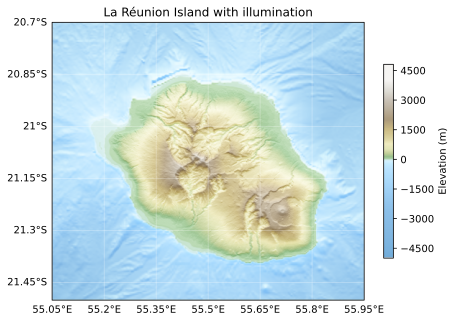

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pycpt
from matplotlib.colors import LightSource
from pygmrt.tiles import download_tiles

# La Réunion bbox [west, south, east, north]
bbox = [55.05, -21.5, 55.95, -20.7]

# Download
tiles = download_tiles(bbox=bbox, resolution="medium")

# Remove NaNs and smooth a bit for better visualization
topo = tiles.read(1)
topo[np.isnan(topo)] = 0
vmax = abs(topo).max()
bbox = tiles.bounds
extent = (bbox.left, bbox.right, bbox.bottom, bbox.top)
palette = pycpt.read("wiki-france")
palette.interpolate(256)

# Create figure
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Hillshade
sun = LightSource(azdeg=0, altdeg=20)
shade = sun.shade(
    topo,
    cmap=palette.cmap,
    norm=palette.norm,
    vert_exag=0.05,
    blend_mode="soft",
)
ax.imshow(shade, extent=extent, origin="upper", transform=ccrs.PlateCarree())

# Extra map features
palette.colorbar(ax=ax, label="Elevation (m)", shrink=0.5)
ax.set_extent(extent)
gridlines = ax.gridlines(draw_labels=True, color="white", alpha=0.3)
gridlines.top_labels = False
gridlines.right_labels = False
ax.set_title("La Réunion Island with illumination")

plt.show()

## Example: Colombia relief

Here's another example showing the topography and bathymetry of Colombia, demonstrating the package's capability to handle larger areas with different color palettes.

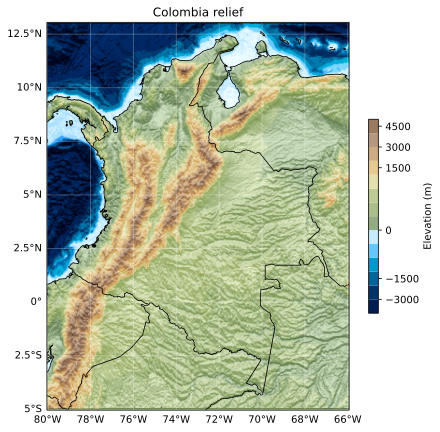

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pycpt
from cartopy import feature as cfeature
from matplotlib.colors import LightSource
from pygmrt.tiles import download_tiles

# Colombia bbox [west, south, east, north]
bbox = [-80.0, -5.0, -66.0, 13.0]

# Download
tiles = download_tiles(bbox=bbox, resolution="low")

# Remove NaNs and smooth a bit for better visualization
topo = tiles.read(1)
topo[np.isnan(topo)] = 0
vmax = abs(topo).max()
bbox = tiles.bounds
extent = (bbox.left, bbox.right, bbox.bottom, bbox.top)
palette = pycpt.read("colombia")

# Create figure
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Hillshade
sun = LightSource(azdeg=0, altdeg=60)
shade = sun.shade(
    topo,
    cmap=palette.cmap,
    norm=palette.norm,
    vert_exag=0.5,
    blend_mode="soft",
)
ax.imshow(shade, extent=extent, origin="upper", transform=ccrs.PlateCarree())

# Extra map features
palette.colorbar(ax=ax, label="Elevation (m)", shrink=0.5)
ax.set_extent(extent)
ax.coastlines(color="k", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, edgecolor="k", linewidth=0.8)
gridlines = ax.gridlines(draw_labels=True, color="white", alpha=0.3)
gridlines.top_labels = False
gridlines.right_labels = False
ax.set_title("Colombia relief")

plt.show()

## API Reference

In [8]:
help(download_tiles)

Help on function download_tiles in module pygmrt.tiles:

download_tiles(*, bbox: 'Sequence[float]' = None, save_directory: 'str | Path' = './geotiff', resolution: 'Resolution' = 'medium', overwrite: 'bool' = False) -> 'rasterio.DatasetReader'
    Download tiles and return the rasterio dataset.
    
    Parameters
    ----------
    bbox : sequence of float
        Bounding box in WGS84 degrees as ``[west, south, east, north]``.
    save_directory : str or pathlib.Path
        Destination directory path where files will be written. Created if
        needed.
    resolution : {"low", "medium", "high"}, default "medium"
        Named resolution level; mapped internally to provider-specific datasets.
    overwrite : bool, default False
        If ``False``, reuse existing files. If ``True``, force re-download.
    
    Returns
    -------
    rasterio.DatasetReader
        Opened rasterio dataset for the downloaded GeoTIFF. The caller is
        responsible for closing the dataset.
    
  

## Development

### Setting up development environment

```bash
git clone https://github.com/leonard-seydoux/pygmrt.git
cd pygmrt

# Install in development mode with UV
uv sync --all-extras

# Or with pip
pip install -e ".[dev,docs]"
```

### Running tests (future)

```bash
# With UV
uv run pytest

# With pip
pytest
```

### Building documentation

This README and images were generated from `docs/readme.ipynb`. To regenerate everything:

```bash
# Build both logo and README with images
cd docs && make

# Or build individually
make logo    # Build logo only
make readme  # Build README and images only
```

## Contributing

Contributions are welcome! Please feel free to submit a Pull Request.

## License

This project is licensed under the MIT License - see the [LICENSE](LICENSE) file for details.

## Acknowledgments

- [GMRT Synthesis](https://www.gmrt.org/) for providing open access to global bathymetry data
- [Lamont-Doherty Earth Observatory](https://www.ldeo.columbia.edu/) for maintaining the GMRT database
- Color palettes from [cpt-city](http://seaviewsensing.com/pub/cpt-city/) via [pycpt-city](https://github.com/leonard-seydoux/pycpt-city)

